## Playing the Dice Blackjack with Q-learing agent

**Prepared by:** Makar Korchagin, Ilya Zherebtsov, Rinat Prochii, Aibek Akhmetkazy and Mukhail Gubanov

In [12]:
import os

import gymnasium as gym
import numpy as np
from tqdm import trange

from src.agent import QLearningAgent
from src.env import DiceBlackJack
from src.visualization import (
    convert_q_table,
    mp4_to_gif,
    plot_policy_tables_18,
    show_inference_stats,
    show_training_stats,
)


In [13]:
os.makedirs("./analysis", exist_ok=True)

You may unveil the training process by redirecting the logs to the file and analyse then later.

In [14]:
import logging

logging.basicConfig(
    level=logging.WARNING,
    filemode="w",
    filename="./analysis/training.log",
    format="[%(levelname)s] %(message)s",
)
logging.logProcesses = False

### Environment

The Balckjack game is the game, that use a pair of dice instead of cards as a source of randomness. To get familiar with the game rules, you may see the original source at this [link](https://www.chessandpoker.com/dice_blackjack.html).

The Dice Blackjack has a state vector $\bold{s} = [p, d_1, d_2] \in \mathbb{S}$, 

where:

$p \in [0, 27] \subset \mathbb{N}_0$ - the sum of the previous rolls;

$d_1, d_2 \in [0, 6] \subset \mathbb{N}_0$ - the rolled values of first and second die (0 value is used to indicate final states, when no rolling is available).

The action space consists of 6 actions: 

0 - hit the first die (**H1**);
1 - hit the second die (**H2**);
2 - hit the sum (**HΣ**);

3 - stack the first die (**S1**);
4 - stack the second die (**S2**);
5 - stack the sum (**SΣ**).

The game ends with on of four possible rewards:

-1 - the player got busted (scored more than 21 points) or got less points than the dealer;
0 - the game ended with a tie;
1 - the player won over the dealer or dealer got busted;
2 - the player rolled a Blackjack combination (2 double values in first two rolls).

You may play the game by launching the environment file `/src/env.py` directly.

In [ ]:
learning_rate = 0.10
n_episodes = 400_000

env = DiceBlackJack()
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = QLearningAgent(env=env, n_episodes=n_episodes, seed=0x42)

### Training
Using the qrpper from gymnasium library, we can train the model and plot the training in two lines. To speed up the training, we have defined non-linear epsilon decay

$$\varepsilon(r) = \max(1 - \sqrt[3]{1.8r}, 0.02),$$

where $r \in [0, 1] \subset \mathbb{R}$ - the normalized training progress.

In [ ]:
decay = lambda x: max(1 - np.power(1.8 * x, 0.33), 0.02)
training_error = agent.train(learning_rate=learning_rate, epsilon_decay=decay)

Training: 100%|██████████| 400000/400000 [03:24<00:00, 1952.74it/s]


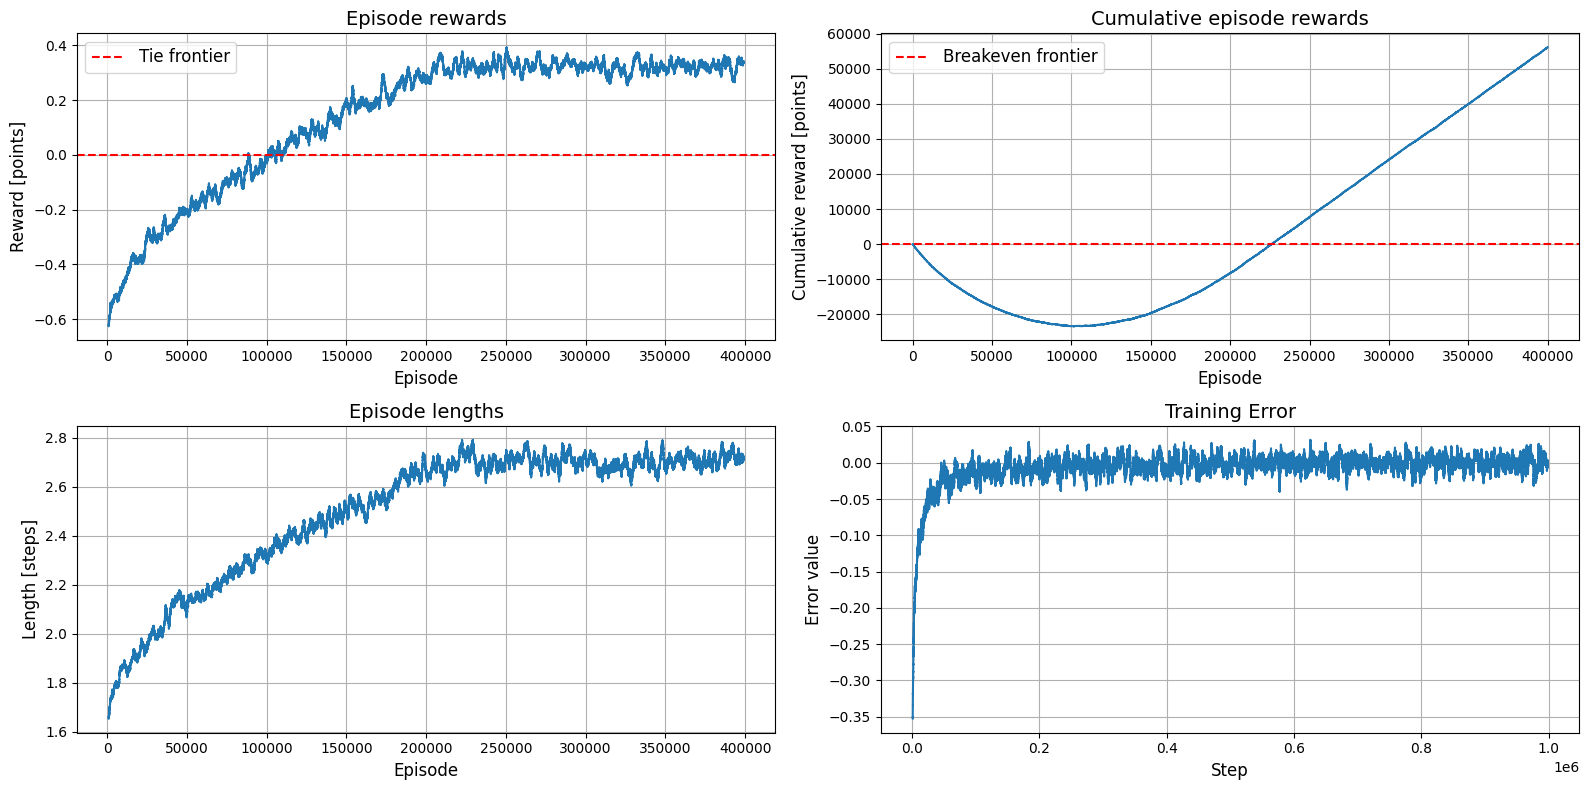

In [17]:
rolling_length = 2000
figure = show_training_stats(env, training_error, rolling_length)
figure.savefig("./analysis/training.jpg", dpi=300)

### Policy representation
By converting the Q-table to the heatmaps, we reveal the agent's logic, that it has obtained during the training.

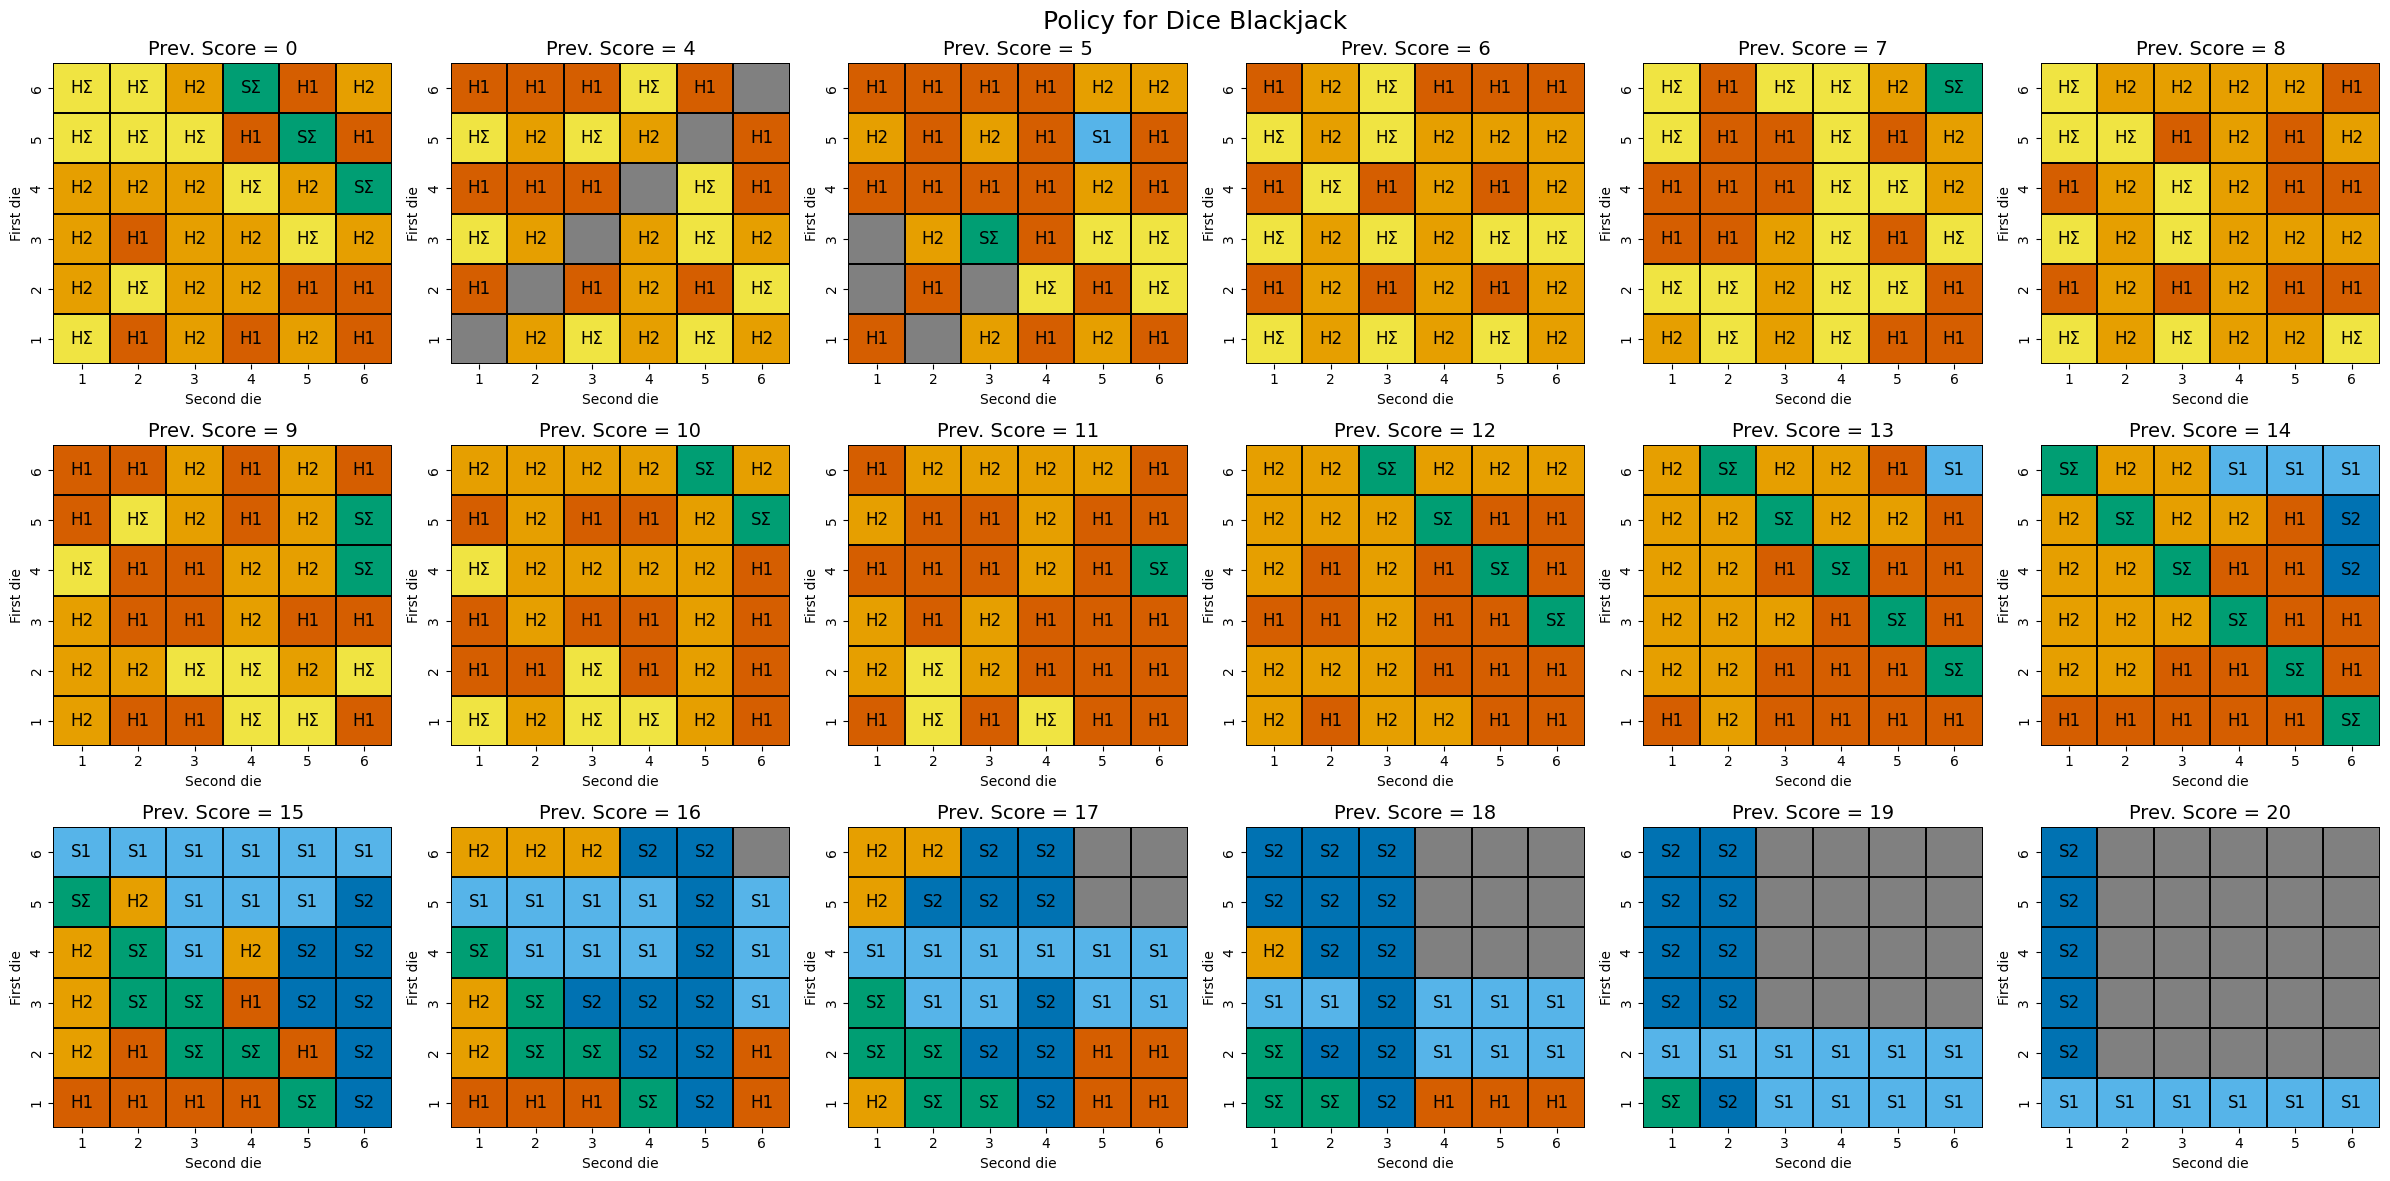

In [18]:
action_info = {
    0: ("H1", "#D55E00"),
    1: ("H2", "#E69F00"),
    2: ("HΣ", "#F0E442"),
    3: ("S1", "#56B4E9"),
    4: ("S2", "#0072B2"),
    5: ("SΣ", "#009E73"),
}

action_table = convert_q_table(agent.get_q_table())
figure = plot_policy_tables_18(action_table, action_info)
figure.savefig("./analysis/policy.jpg", dpi=300)

### Inference

In [19]:
n_episodes = 50_000
env = DiceBlackJack(render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder="./analysis",
    fps=1,
    video_length=60,
    episode_trigger=lambda x: x == 0,
    name_prefix="dice-blackjack",
)
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

c:\Users\mekor\Documents\Skoltech\Term-7\RL\dice-blackjack-mdp\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\mekor\Documents\Skoltech\Term-7\RL\dice-blackjack-mdp\analysis folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [20]:
for _ in trange(n_episodes, desc="Inference"):
    obs, _ = env.reset()
    done = False
    while not done:
        action = agent.respond(obs)
        obs, reward, done, _, _ = env.step(action)

Inference: 100%|██████████| 50000/50000 [00:23<00:00, 2109.77it/s]


In [21]:
mp4_to_gif(folder="./analysis")

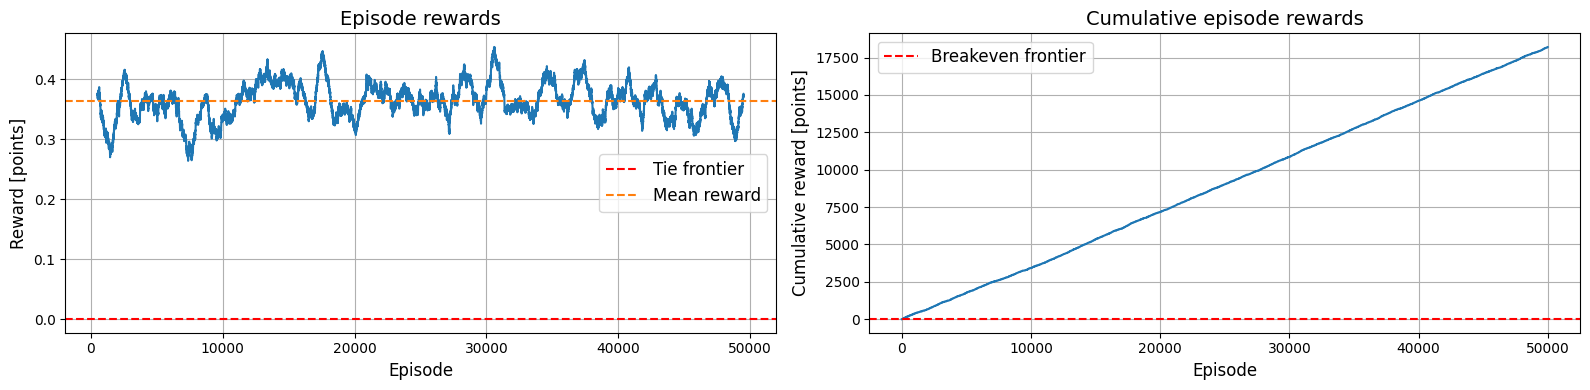

In [22]:
figure = show_inference_stats(env)
figure.savefig("./analysis/validation.jpg", dpi=300)